In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from src.probly.representation.dropout import Dropout
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.probly.tasks import selective_prediction, out_of_distribution_detection
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.probly.measures.distributions import total_uncertainty_entropy, epistemic_uncertainty_entropy

/Users/paulhofman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device = torch.device('cpu')
print(f'Using device {device}')
transforms = T.Compose([T.ToTensor(), torch.flatten])

train = torchvision.datasets.FashionMNIST(root='~/datasets/', train=True, download=True, transform=transforms)
test = torchvision.datasets.FashionMNIST(root='~/datasets/', train=False, download=True, transform=transforms)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

ood = torchvision.datasets.MNIST(root='~/datasets/', train=False, download=True, transform=transforms)
ood_loader = DataLoader(ood, batch_size=256, shuffle=False)

# small fully connected neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Using device cpu


In [3]:
model = Dropout(net, 0.5)
print([child for child in model.model.children()])
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
for _ in tqdm(range(20)):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x, 1)
        y_pred = torch.squeeze(y_pred)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
# compute accuracy on test set
correct = 0
total = 0
model.eval()
for x, y in test_loader:
    y_pred = model(x, 100)
    y_pred = model(x, 100).mean(axis=1)
    y_pred = y_pred.argmax(axis=1)
    correct += (y_pred == y).sum().item()
    total += y.size(0)
print(f"Accuracy: {correct / total}")

[Linear(in_features=784, out_features=100, bias=True), Dropout(p=0.5, inplace=False), Linear(in_features=100, out_features=100, bias=True), Dropout(p=0.5, inplace=False), Linear(in_features=100, out_features=10, bias=True), ReLU()]


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


Accuracy: 0.8148


In [7]:
@torch.no_grad()
def torch_get_outputs(model, loader, device):
    model = model.to(device)
    outputs = torch.empty(0, device=device)
    targets = torch.empty(0, device=device)
    for input, target in loader:
        input, target = input.to(device), target.to(device)
        targets = torch.cat((targets, target), dim=0)
        outputs = torch.cat((outputs, model(input, 20)), dim=0)
    return outputs, targets

preds_test, targets_test = torch_get_outputs(model, test_loader, device)
preds_ood, _ = torch_get_outputs(model, ood_loader, device)
preds_test = F.softmax(preds_test, dim=2)
print(preds_test[0,:,0])
preds_ood = F.softmax(preds_ood, dim=2)
unc_test = epistemic_uncertainty_entropy(preds_test)
unc_ood = epistemic_uncertainty_entropy(preds_ood)
auroc = out_of_distribution_detection(unc_test, unc_ood)
print(f'AUROC: {auroc}')

tensor([7.3557e-04, 1.7512e-03, 3.0648e-03, 8.4829e-04, 7.9379e-04, 7.5064e-05,
        7.2889e-05, 1.9384e-05, 1.9654e-03, 1.1435e-04, 4.7033e-04, 2.0998e-03,
        1.4674e-03, 1.4668e-03, 5.7652e-03, 1.3752e-03, 4.0437e-04, 3.5987e-04,
        1.2210e-03, 6.1796e-03])
(10000, 20, 10)
(10000, 20, 10)
AUROC: 0.8398617299999999


AUROC: 0.05813101462178149


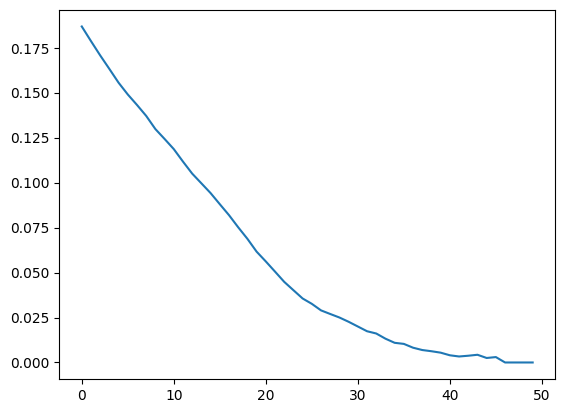

In [20]:
tot_unc_test = total_uncertainty_entropy(preds_test)
# zero-one-loss
loss = (preds_test.mean(axis=1).argmax(axis=1) != targets_test).int().cpu().numpy()
auroc, bins = selective_prediction(tot_unc_test, loss)
print(f'AUROC: {auroc}')
plt.plot(bins)
plt.show()